# Homework 6 solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Cepheids

We want to fit a line to Cepheid period-magnitudes and find the error in the fit.

Let's start by reading in the data and making a plot.  We only care about 3 columns, "logP", "MK", and "σmM"

In [2]:
data = np.genfromtxt("cepheids.txt", names=True)

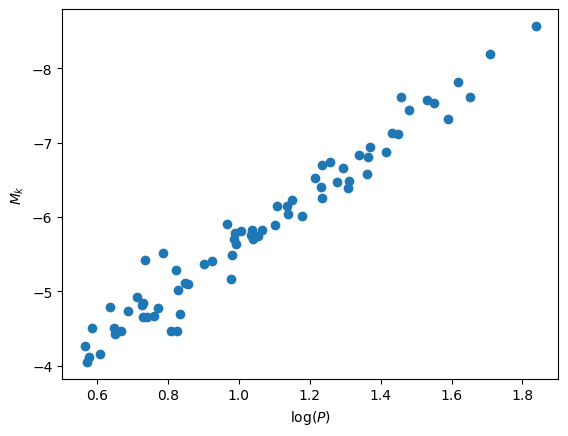

In [3]:
fig, ax = plt.subplots()
ax.scatter(data["logP"], data["MK"])
ax.set_xlabel(r"$\log(P)$")
ax.set_ylabel("$M_k$")
ax.invert_yaxis()

Storm et al. 2011 fit this data to 

$$M = a (\log_{10}{P} - 1.0) + b$$

so our model function will be:

$$Y(x; a_1, a_2) = a_1 + a_2 x$$

In class, we saw that

In [4]:
logP = data["logP"]
Mk = data["MK"]
err = data["σmM"]

We'll use the general linear least squares from class:

In [5]:
def basis(x, M=3):
    """ the basis function for the fit, x**n"""
    
    j = np.arange(M)
    return x**j

This is modified from class to return the matrix ${\bf A}^\intercal{\bf A}$.

In [6]:
def general_regression(x, y, yerr, M):
    """ here, M is the number of fitting parameters.  We will fit to
        a function that is linear in the a's, using the basis functions
        x**j """

    N = len(x)

    # construct the design matrix -- A_{ij} = Y_j(x_i)/sigma_i -- this is
    # N x M.  Each row corresponds to a single data point, x_i, y_i
    A = np.zeros((N, M), dtype=np.float64)

    for i in range(N):
        A[i,:] = basis(x[i], M) / yerr[i]

    # construct the MxM matrix for the linear system, A^T A:
    ATA = np.transpose(A) @ A

    print("condition number of A^T A:", np.linalg.cond(ATA))

    # construct the RHS
    b = np.transpose(A) @ (y / yerr)

    # solve the system
    a = np.linalg.solve(ATA, b)

    # return the chisq
    chisq = 0
    for i in range(N):
        chisq += (np.sum(a*basis(x[i], M)) - y[i])**2 / yerr[i]**2

    chisq /= N-M

    return a, ATA, chisq

In [7]:
a, ATA, chisq = general_regression(logP-1.0, Mk, err, 2)

condition number of A^T A: 8.494389613454842


Here's our fit:

In [8]:
a

array([-5.64557103, -3.28969021])

This agrees well with what Storm et al. found.

Now let's look at the errors.  We want to compute:

$${\bf C} = ({\bf A}^\intercal {\bf A})^{-1}$$

In [9]:
ATA

array([[64368.21617536,  6779.44744347],
       [ 6779.44744347,  8483.83758629]])

In [10]:
C = ATA**-1
C

array([[1.55356177e-05, 1.47504647e-04],
       [1.47504647e-04, 1.17871186e-04]])

and then the uncertainties are the square root of the diagonals:

$$\sigma_j = \sqrt{C_{jj}}$$

In [11]:
sigmas = np.sqrt(np.linalg.diagonal(np.linalg.inv(ATA)))
sigmas

array([0.00411865, 0.01134475])

This says that our fit parameters are:

In [12]:
print(f"intercept: {a[0]:6.3f} +/- {sigmas[0]:6.3f}")
print(f"slope    : {a[1]:6.3f} +/- {sigmas[1]:6.3f}")

intercept: -5.646 +/-  0.004
slope    : -3.290 +/-  0.011


Finally let's plot the fit:

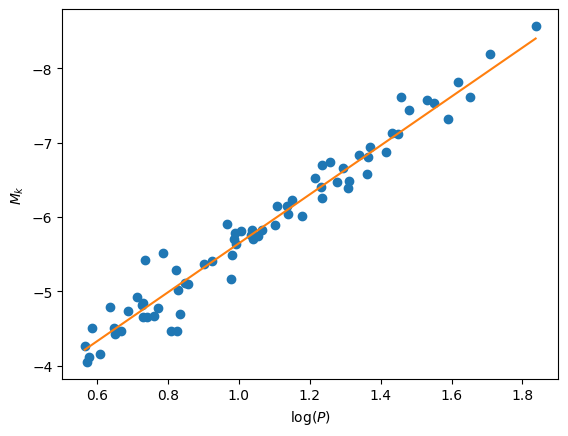

In [13]:
ax.plot(logP, (a[0] - a[1]) + a[1] * logP, color="C1")
fig

## 2. Interpolation

The reaction rate for the 3-$\alpha$ process is

$$q_{3\alpha} = 5.09\times 10^{11} \rho^2 Y^3 T_8^{-3} e^{-44.027/T8}~\mathrm{erg~g^{-1}~s^{-1}}$$


In [14]:
def lam(T):
    """this is the triple alpha reaction rate / rho^2 Y^3"""
    T8 = T/1e8
    return 5.09e11 * T8**-3 * np.exp(-44.027/T8)

We want to tabulate the temperature portion of this,

$$\lambda(T) = 5.09\times 10^{11} T_8^{-3} e^{-44.027/T8}$$

this at 10 points, equally spaced in log between $T = 10^8~\mathrm{K}$ and $5\times 10^9~\mathrm{K}$.

First let's create that tabulation:

In [16]:
Ts = np.logspace(np.log10(1.e8), np.log10(5.e9), 10)
logTs = np.log10(Ts)
logTs

array([8.        , 8.18877444, 8.37754889, 8.56632333, 8.75509778,
       8.94387222, 9.13264667, 9.32142111, 9.51019556, 9.69897   ])

In [17]:
loglams = np.log10(lam(Ts))
loglams

array([-7.41396537, -1.23984259,  2.55813006,  4.81759586,  6.08091109,
        6.69923995,  6.89995379,  6.83027077,  6.58551152,  6.22739411])

Now, given our array of $\log(T)$ and $\log(\lambda)$, we want to do cubic Lagrange interpolation on the 4 points that surround the desired value, $(\log(T))_0$.

Given 4 points, $(\log(T))_i$, $(\log(T))_{i+1}$, $(\log(T))_{i+2}$, $(\log(T))_{i+3}$, we should choose $i$ such that

$$(\log(T))_{i+1} \le (\log(T))_0 \le (\log(T))_{i+2}$$

e.g., there should be 2 points on each side of our desired temperature, except at the start or end of the sequence, where this is not possible, so we would just need to use the closest 4 points to the desired temperature.

Here's a function that finds that index:

In [20]:
def find_index(logTs, logT0):
    """find i such that logTs[i+1] <= logT0 <= logTs[i+2]"""
    return max(0, min(len(logTs)-4, np.argwhere(logTs > logT0)[0][0] - 2))

To test this, here's a case where we are near the beginning of the tabulation:

In [21]:
find_index(logTs, 8.1)

0

and heres a test where we are in the middle:

In [22]:
find_index(logTs, 8.8)

np.int64(3)

Comparing to the `logTs` array above, both give the result we want.

Here's our Lagrange interpolation class from lecture.  We will use it in a slightly different fashion though.  Instead of passing in the entire set of data, we will only pass in the 4 points
centered on the value at which we wish to interpolate.

In [24]:
class LagrangePoly:
    """ a general class for creating a Lagrange polynomial 
    representation of a function """

    def __init__(self, xp, fp):
        self.xp = xp
        self.fp = fp

    def evalf(self, x0):
        """ given a point x0 and a function func, fit a Lagrange
        polynomial through the control points and return the
        interpolated value at x """

        f = 0.0

        # sum over points
        for m in range(len(self.xp)):

            # create the Lagrange basis polynomial for point m
            l = 1

            for n in range(len(self.xp)):
                if n == m:
                    continue

                l *= (x0 - self.xp[n])/(self.xp[m] - self.xp[n])

            f += self.fp[m]*l

        return f

In [29]:
logT0 = 9.6

In [31]:
idx = find_index(logTs, logT0)
l = LagrangePoly(logTs[idx:idx+4], loglams[idx:idx+4])
10**l.evalf(logT0)

np.float64(2663771.7432654747)

Now we can test this out by randomly trying points to interpolate

In [37]:
rng = np.random.default_rng()
max_err = -1
for i in range(25):
    logT0 = rng.uniform(np.log10(1.e8), np.log10(5.e9))

    true_rate = lam(10**logT0)

    idx = find_index(logTs, logT0)
    l = LagrangePoly(logTs[idx:idx+4], loglams[idx:idx+4])
    interp_rate = 10.0**l.evalf(logT0)

    print(f"T = {10.0**logT0:9.4g}; rate: true = {true_rate:10.5g}, interp = {interp_rate:10.5g}")
    max_err = max(max_err, abs(interp_rate - true_rate)/true_rate)

print(f"maximum relative error = {max_err:9.4g}")

T = 3.004e+09; rate: true = 4.3369e+06, interp = 4.3402e+06
T = 2.049e+08; rate: true =     27.502, interp =     27.983
T = 1.073e+09; rate: true = 6.8039e+06, interp = 6.8272e+06
T = 1.636e+08; rate: true =    0.23999, interp =    0.24209
T = 4.526e+08; rate: true = 3.2751e+05, interp = 3.3019e+05
T = 1.589e+08; rate: true =    0.11664, interp =    0.11716
T = 1.135e+08; rate: true = 4.9127e-06, interp = 4.7348e-06
T = 1.144e+09; rate: true = 7.2468e+06, interp = 7.2702e+06
T = 3.161e+09; rate: true = 4.0036e+06, interp = 4.0046e+06
T = 8.543e+08; rate: true = 4.7181e+06, interp = 4.7235e+06
T = 2.356e+09; rate: true = 6.0053e+06, interp = 6.0121e+06
T = 1.391e+09; rate: true = 7.9825e+06, interp = 7.9861e+06
T = 2.338e+08; rate: true =     263.65, interp =     264.45
T = 4.868e+08; rate: true = 5.2127e+05, interp = 5.2512e+05
T = 1.727e+09; rate: true = 7.7212e+06, interp = 7.7381e+06
T = 1.393e+08; rate: true =  0.0035676, interp =  0.0035022
T = 3.349e+08; rate: true =      26450, 